In [90]:
'''
https://stackoverflow.com/questions/19873596/convex-hull-area-in-python

https://towardsdatascience.com/the-concave-hull-c649795c0f0f
'''

'\nhttps://stackoverflow.com/questions/19873596/convex-hull-area-in-python\n\nhttps://towardsdatascience.com/the-concave-hull-c649795c0f0f\n'

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import json
import math
from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats
from scipy.stats import gaussian_kde

from scipy.spatial import ConvexHull, convex_hull_plot_2d

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

from scipy.signal import argrelextrema,argrelmax

In [174]:
from scipy.spatial import Delaunay
import numpy as np

# https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points

#  matlab boundary - https://stackoverflow.com/questions/31836709/what-algorithm-does-matlabs-boundary-function-use

# https://www.mathworks.com/help/matlab/ref/boundary.html

#  javascript implementation of hull - https://github.com/AndriiHeonia/hull

# alpha shape https://en.wikipedia.org/wiki/Alpha_shape
# https://doc.cgal.org/latest/Alpha_shapes_2/index.html

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [175]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

210.csv
maximas  [1.1003, 0.79905, 0.76052, 0.63161, -0.61803, -0.62759, -0.69834]
extremas [1.1003, 0.79905, 0.76052, 0.63161, -0.61803, -0.62759, -0.69834]
maximas  [0.51932]
extremas [0.51932]
maximas  [3.3916, 2.1948, 1.9966500000000007, 1.4717265182792898, 1.4026, 1.3237568172040706, 1.2941, 1.2891, 1.2711741544779795, 1.2534500000000002, 1.1952, 1.1341, 1.1203, 0.87285, 0.8696299999999999, 0.78009, 0.73933, 0.65998, -0.47777, -0.5223300000000001, -0.52642, -0.53876, -0.5794600000000001, -0.64905, -0.6867, -0.69425, -0.7115, -0.7138399999999999, -0.79175, -0.90633, -0.9078, -0.94018, -0.95645, -1.0406, -1.1362]
extremas [3.3916, 2.1948, 1.9966500000000007, 1.4717265182792898, 1.4026, 1.3237568172040706, 1.2941, 1.2891, 1.2711741544779795, 1.2534500000000002, 1.1952, 1.1341, 1.1203, 0.87285, 0.8696299999999999, 0.78009, 0.73933, 0.65998, -0.47777, -0.5223300000000001, -0.52642, -0.53876, -0.5794600000000001, -0.64905, -0.6867, -0.69425, -0.7115, -0.7138399999999999, -0.79175, -0.90

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


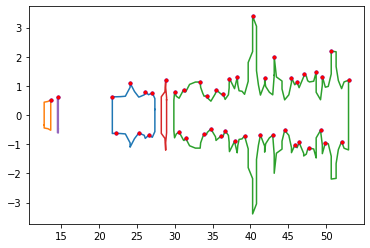

area = 59.07313967271047 , length = 102.02828951073394, bounds = (12.729, -3.3916, 52.959, 3.3916), slope = 0.16861048968431516


In [183]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width']

fileName = []
area = []
length = []
height = []
width = []
        
folder = 'newData'
file = '210.csv'
df = pd.read_csv('data/input/{}/{}'.format(folder,file))
print(file)
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
# print(inside)
points = np.vstack([x[inside], y[inside]]).T
# print(points)

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.4, only_outer=True)


# Plotting the output
plt.figure()
#         plt.plot(points[:, 0], points[:, 1], '.')
# plt.ylim([-1, 1])
#         for i, j in edges:
#         #     print(i, j, points[[i, j], 0], points[[i, j], 1])

#             plt.plot(points[[i, j], 0], points[[i, j], 1])


#         plt.show()

orderedBoundaries = stitch_boundaries(edges)

maxL = []
index = []
for i in range(len(orderedBoundaries)):
#     print(len(orderedBoundaries[i]))
    if len(orderedBoundaries[i]) > 10:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)

#         print(index, maxL)

X = []
Y = []
count = 0
shapeData = []
# print(orderedBoundaries)


for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            bound.append((points[j[0]][0], points[j[0]][1]))
            bound.append((points[j[1]][0], points[j[1]][1]))

            X.append(points[j[0]][0])
            X.append(points[j[1]][0])
            Y.append(points[j[0]][1])
            Y.append(points[j[1]][1])

            count = count + 1
        else:
            bound.append((points[j[1]][0], points[j[1]][1]))

            X.append(points[j[1]][0])
            Y.append(points[j[1]][1])

    poly = Polygon(bound)
#             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
    shapeData.append(poly)

polygon = MultiPolygon(shapeData)
minx,miny,maxx,maxy = polygon.bounds

slope = (maxy-miny)/(maxx-minx)

#         plt.plot([minx,maxx], [miny,maxy])
for geom in polygon.geoms:
    x,y = geom.exterior.xy


#     pp = sorted(y, reverse=True)
#     ppp = pp[:4]
#     print(type(y))           

    plt.plot(x,y)
    
    npx = np.array(x)
    npy = np.array(y)
    
    lmax = argrelmax(npy)[0]
    exmax = argrelextrema(npy, np.greater)[0]
    
    lyp = npy[lmax]
    eyp = npy[exmax]
    
#     maxima = pp[argrelmax(npy, np.greater)[0]]
    lxp = npx[lmax]
    exp = npx[exmax]    
    
    plt.plot(lxp, lyp, '.', color='blue')
    plt.plot(exp, eyp, '.', color='red')
    
    print("maximas ",sorted(lyp, reverse=True))
    print("extremas", sorted(eyp, reverse=True))
    
    
plt.show()

#         ['id', 'area', 'length', 'height', 'width']

fileName.append(file)
area.append(round(polygon.area, 4))
length.append(round(polygon.length, 4))
h = abs(maxy - miny)
height.append(round(h, 4))
w = abs(maxx - minx)
width.append(round(w, 4))

print("area = {} , length = {}, bounds = {}, slope = {}".format(polygon.area , polygon.length, polygon.bounds, slope))
        
# print(fileName)
# print(area)
# print(length)
# print(height)
# print(width)
# similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width]), columns = columns)

210.csv
maximas  [1.1003, 0.79905, 0.76052, 0.63161, -0.61803, -0.62759, -0.69834]
extremas [1.1003, 0.79905, 0.76052, 0.63161, -0.61803, -0.62759, -0.69834]
maximas  [0.51932]
extremas [0.51932]
maximas  [3.3916, 2.1948, 1.9966500000000007, 1.4717265182792898, 1.4026, 1.3237568172040706, 1.2941, 1.2891, 1.2711741544779795, 1.2534500000000002, 1.1952, 1.1341, 1.1203, 0.87285, 0.8696299999999999, 0.78009, 0.73933, 0.65998, -0.47777, -0.5223300000000001, -0.52642, -0.53876, -0.5794600000000001, -0.64905, -0.6867, -0.69425, -0.7115, -0.7138399999999999, -0.79175, -0.90633, -0.9078, -0.94018, -0.95645, -1.0406, -1.1362]
extremas [3.3916, 2.1948, 1.9966500000000007, 1.4717265182792898, 1.4026, 1.3237568172040706, 1.2941, 1.2891, 1.2711741544779795, 1.2534500000000002, 1.1952, 1.1341, 1.1203, 0.87285, 0.8696299999999999, 0.78009, 0.73933, 0.65998, -0.47777, -0.5223300000000001, -0.52642, -0.53876, -0.5794600000000001, -0.64905, -0.6867, -0.69425, -0.7115, -0.7138399999999999, -0.79175, -0.90

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


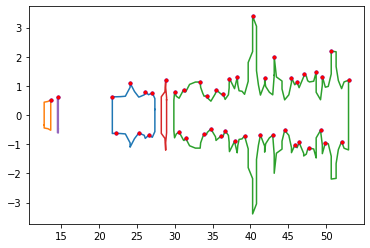

area = 59.07313967271047 , length = 102.02828951073394, bounds = (12.729, -3.3916, 52.959, 3.3916), slope = 0.16861048968431516
211.csv
maximas  [2.0447725860279378, 1.953620958613904, 1.8324000000000007, 1.7237999853988122, 1.6515152081265825, 1.6381094381472876, 1.472240741266374, 1.4638, 1.4405, 1.3564348954307741, 1.353647323254332, 1.3382, 1.1416325646311825, 1.1358, 1.1338, 1.0581, 1.0358, 1.0353, 0.97821, 0.94833, 0.79498, -0.5482199999999999, -0.57224, -0.62921, -0.68479, -0.70095, -0.70213, -0.7467600000000001, -0.75813, -0.7982199999999999, -0.80821, -0.8318200000000001, -0.92213, -0.95502, -0.99927, -1.0, -1.0918, -1.2365, -1.3011, -1.3136]
extremas [2.0447725860279378, 1.953620958613904, 1.8324000000000007, 1.7237999853988122, 1.6515152081265825, 1.6381094381472876, 1.472240741266374, 1.4638, 1.4405, 1.3564348954307741, 1.353647323254332, 1.3382, 1.1416325646311825, 1.1358, 1.1338, 1.0581, 1.0358, 1.0353, 0.97821, 0.94833, 0.79498, -0.5482199999999999, -0.57224, -0.62921, -

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


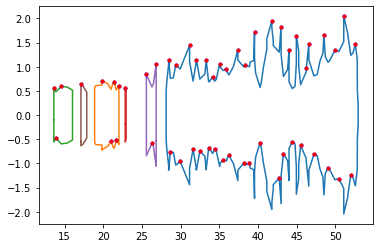

area = 62.44042575518492 , length = 104.39343629905926, bounds = (13.609000000000002, -2.044772586027938, 52.94600000000001, 2.0447725860279378), slope = 0.10396179607127833
212.csv
maximas  [0.40677]
extremas [0.40677]
maximas  [3.863922081201912, 2.268466949706959, 2.040442453856515, 2.0219999818992034, 1.7239500000000003, 1.5883924674651386, 1.419, 1.3831503726913694, 1.3822, 1.3651678020823308, 1.318090662577615, 1.2743149353959509, 1.2012, 1.1854, 1.1544, 1.1078, 0.9996, 0.78422, 0.7461300000000001, -0.44086, -0.58481, -0.64399, -0.68214, -0.6832699999999999, -0.73414, -0.74311, -0.8144899999999999, -0.8483799999999999, -0.85231, -0.93285, -0.95879, -0.97483, -0.99502, -1.0352, -1.1212, -1.2491, -1.33]
extremas [3.863922081201912, 2.268466949706959, 2.040442453856515, 2.0219999818992034, 1.7239500000000003, 1.5883924674651386, 1.419, 1.3831503726913694, 1.3822, 1.3651678020823308, 1.318090662577615, 1.2743149353959509, 1.2012, 1.1854, 1.1544, 1.1078, 0.9996, 0.78422, 0.74613000000

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


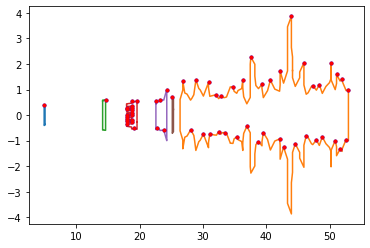

area = 64.66641142566559 , length = 120.34433589525555, bounds = (4.9403, -3.863922081201912, 52.997, 3.863922081201912), slope = 0.16080680035049896
213.csv
maximas  [0.6916899999999999]
extremas [0.6916899999999999]
maximas  [2.685292213243564, 2.196, 2.003436026289769, 1.7070226733995073, 1.6906, 1.4630488768729153, 1.4149, 1.3144, 1.3126, 1.2502, 1.195, 1.0704, 0.98454, 0.97255, 0.91181, 0.90232, -0.59472, -0.61432, -0.66382, -0.67972, -0.68087, -0.7336699999999999, -0.78035, -0.80901, -0.82124, -0.8577799999999999, -0.94409, -1.1882, -1.2822, -1.3090000000000002, -1.3835]
extremas [2.685292213243564, 2.196, 2.003436026289769, 1.7070226733995073, 1.6906, 1.4630488768729153, 1.4149, 1.3144, 1.3126, 1.2502, 1.195, 1.0704, 0.98454, 0.97255, 0.91181, 0.90232, -0.59472, -0.61432, -0.66382, -0.67972, -0.68087, -0.7336699999999999, -0.78035, -0.80901, -0.82124, -0.8577799999999999, -0.94409, -1.1882, -1.2822, -1.3090000000000002, -1.3835]
maximas  [0.73688]
extremas [0.73688]
maximas  [1.

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


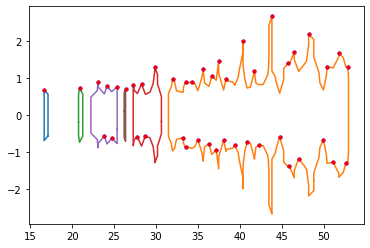

area = 58.321893849165185 , length = 97.6755823024765, bounds = (16.663, -2.685292213243564, 52.938, 2.685292213243564), slope = 0.14805194835250524
214.csv
maximas  [0.8405299999999999]
extremas [0.8405299999999999]
maximas  [2.2526491691201755, 2.082310468745814, 1.8328, 1.6755859504014319, 1.6442507032968876, 1.6147450768959866, 1.57184659773143, 1.4998806106274063, 1.4671336383203175, 1.3893200300856758, 1.3187, 1.2569, 1.1519, 1.0306, 0.99161, 0.87651, 0.82539, -0.5634097683534834, -0.624, -0.6581, -0.66285, -0.6746300000000001, -0.7552800000000001, -0.89718, -0.91167, -0.96989, -1.0165, -1.0614, -1.1271, -1.1948, -1.1986096033572036, -1.2327, -1.2443]
extremas [2.2526491691201755, 2.082310468745814, 1.8328, 1.6755859504014319, 1.6442507032968876, 1.6147450768959866, 1.57184659773143, 1.4998806106274063, 1.4671336383203175, 1.3893200300856758, 1.3187, 1.2569, 1.1519, 1.0306, 0.99161, 0.87651, 0.82539, -0.5634097683534834, -0.624, -0.6581, -0.66285, -0.6746300000000001, -0.75528000

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


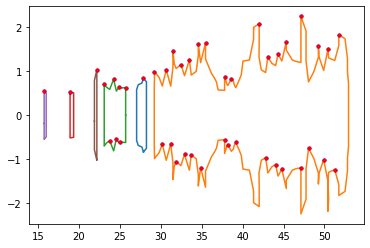

area = 61.66068096829855 , length = 95.06998361821617, bounds = (15.759, -2.252649169120176, 52.945, 2.2526491691201755), slope = 0.12115576663906714
215.csv
maximas  [4.1932, 3.6842638303045963, 3.3642857949672584, 3.3474644620747607, 3.098105694376631, 2.8980728977242465, 2.85431647696334, 2.8409, 2.7156, 2.7088097672380127, 2.1786, 2.1535, 1.9331, 1.7924, 1.5845087709444483, 1.3836, 0.99943, 0.97242, 0.95712, 0.93005, 0.86745, -0.50567, -0.55488, -0.65184, -0.72368, -0.77036, -0.78269, -0.79172, -0.83683, -0.8777200000000001, -0.91762, -0.94799, -1.2331, -1.3109, -1.3267, -1.3912, -1.952467680960088, -2.1991, -2.4704, -2.6803, -2.9852, -3.100546673829048]
extremas [4.1932, 3.6842638303045963, 3.3642857949672584, 3.3474644620747607, 3.098105694376631, 2.8980728977242465, 2.85431647696334, 2.8409, 2.7156, 2.7088097672380127, 2.1786, 2.1535, 1.9331, 1.7924, 1.5845087709444483, 1.3836, 0.99943, 0.97242, 0.95712, 0.93005, 0.86745, -0.50567, -0.55488, -0.65184, -0.72368, -0.77036, -0.7826

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


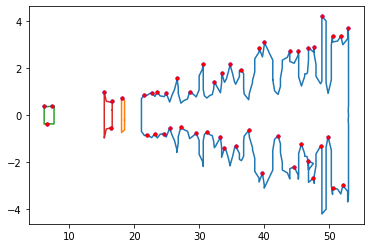

area = 108.99113892692257 , length = 136.99334652169534, bounds = (6.1373, -4.1932, 52.966, 4.1932), slope = 0.17908675662574447
216.csv
maximas  [4.44210866748152, 3.701008024141761, 3.509064852612533, 3.3842, 2.6407, 2.6208687192064257, 2.5651, 2.4145, 2.2657, 2.255847659551413, 2.250488413672288, 1.8935639604746743, 1.8331, 1.7494, 1.4312773763982534, 1.2554637135334548, 1.1360676222921129, 1.0733, 0.82247, -0.60035, -0.63546, -0.64053, -0.66106, -0.80129, -0.8251200000000001, -0.95382, -0.96606, -0.97309, -0.99844, -1.0354, -1.1645, -1.3381, -1.7386, -1.9582, -1.9835, -2.2293, -2.2534, -2.483669645200876, -2.6787892116860257]
extremas [4.44210866748152, 3.701008024141761, 3.509064852612533, 3.3842, 2.6407, 2.6208687192064257, 2.5651, 2.4145, 2.2657, 2.255847659551413, 2.250488413672288, 1.8935639604746743, 1.8331, 1.7494, 1.4312773763982534, 1.2554637135334548, 1.1360676222921129, 1.0733, 0.82247, -0.60035, -0.63546, -0.64053, -0.66106, -0.80129, -0.8251200000000001, -0.95382, -0.9

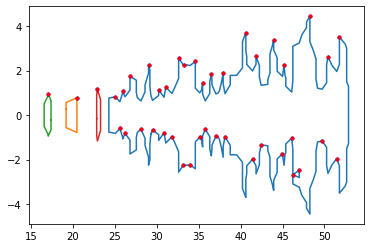

area = 105.22788114792678 , length = 136.4838538394273, bounds = (16.553, -4.442108667481522, 52.872, 4.44210866748152), slope = 0.2446162431499502
217.csv
maximas  [0.36823]
extremas [0.36823]
maximas  [3.8817, 3.6728, 3.558667663331016, 2.9329684883717584, 2.6916, 2.6149633953521114, 2.5578, 2.418112191396909, 2.4134197178461947, 2.243390522700037, 2.2078, 2.207361073649184, 1.5959158996439635, -0.7511399999999999, -0.87123, -0.94516, -1.1583200955902773, -1.3179, -1.389, -1.5812, -1.6401, -1.8065, -1.8216, -2.1075, -2.1773]
extremas [3.8817, 3.6728, 3.558667663331016, 2.9329684883717584, 2.6916, 2.6149633953521114, 2.5578, 2.418112191396909, 2.4134197178461947, 2.243390522700037, 2.2078, 2.207361073649184, 1.5959158996439635, -0.7511399999999999, -0.87123, -0.94516, -1.1583200955902773, -1.3179, -1.389, -1.5812, -1.6401, -1.8065, -1.8216, -2.1075, -2.1773]
maximas  [0.41967]
extremas [0.41967]
maximas  [0.69342, 0.57218, -0.5264]
extremas [0.69342, 0.57218, -0.5264]
maximas  [2.19, 

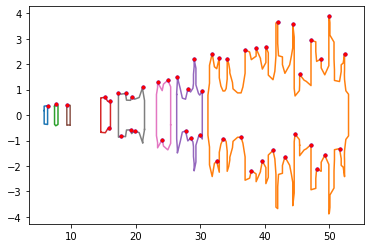

area = 102.09505367193329 , length = 150.16255179460876, bounds = (5.8129, -3.8817, 52.993, 3.8817), slope = 0.16454818874907004
218.csv
maximas  [0.68615]
extremas [0.68615]
maximas  [0.6835100000000001]
extremas [0.6835100000000001]
maximas  [0.38235]
extremas [0.38235]
maximas  [1.046062794605367]
extremas [1.046062794605367]
maximas  [1.0554]
extremas [1.0554]
maximas  [2.8817444459703823, 2.3659580851024065, 1.840700000000001, 1.6545415287031695, 1.4174, 1.348, 1.345473054771235, 1.2489, 0.94058, -0.6561600000000001, -0.71732, -0.73321, -0.8231, -0.91539, -1.0199, -1.1102, -1.2542]
extremas [2.8817444459703823, 2.3659580851024065, 1.840700000000001, 1.6545415287031695, 1.4174, 1.348, 1.345473054771235, 1.2489, 0.94058, -0.6561600000000001, -0.71732, -0.73321, -0.8231, -0.91539, -1.0199, -1.1102, -1.2542]
maximas  [1.8559, 1.3237, 1.2160184233912368, 1.196, 1.0572, 0.99634, 0.92771, 0.84596, 0.8314799999999999, -0.57088, -0.6885, -0.72411, -0.73569, -0.90324, -0.92335, -0.93499, -1

<ipython-input-174-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


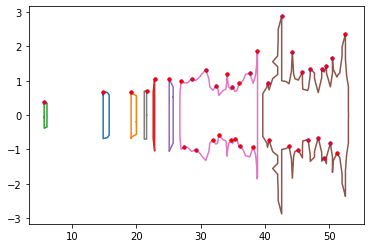

area = 59.235241709375124 , length = 107.57997756205887, bounds = (5.6858, -2.8817444459703823, 52.97, 2.8817444459703823), slope = 0.12189037547300716
219.csv
maximas  [3.7957, 3.7377, 3.5664, 3.239120401628722, 3.2229751650975422, 3.1964597235353844, 3.1753127780576778, 2.9674418580673776, 2.6655980248878435, 2.5951, 2.1244, 1.4958, 1.4602215431691217, 1.195480725107772, 1.12361128084691, 1.1085, 0.9554, -0.63484, -0.66243, -0.74863, -0.7651399999999999, -0.81433, -0.8523299999999999, -0.8918299999999999, -0.90136, -0.95274, -0.96363, -1.1718, -1.4548, -1.723500157547343, -2.236716177754059, -2.3528, -2.8305]
extremas [3.7957, 3.7377, 3.5664, 3.239120401628722, 3.2229751650975422, 3.1964597235353844, 3.1753127780576778, 2.9674418580673776, 2.6655980248878435, 2.5951, 2.1244, 1.4958, 1.4602215431691217, 1.195480725107772, 1.12361128084691, 1.1085, 0.9554, -0.63484, -0.66243, -0.74863, -0.7651399999999999, -0.81433, -0.8523299999999999, -0.8918299999999999, -0.90136, -0.95274, -0.96363

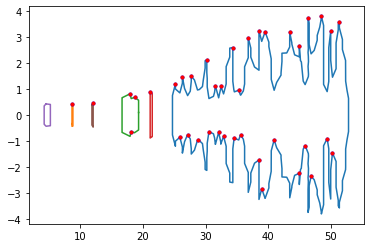

area = 105.76750247207718 , length = 138.1838022354173, bounds = (4.2089, -3.7957, 52.798, 3.7957), slope = 0.156236686828939


In [184]:
# new calculation for shape similarity

# folders = [f for f in listdir("data/input/")]
columns = ['id', 'area', 'length', 'height', 'width']

fileName = []
area = []
length = []
height = []
width = []
        
folders = ['newData']
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        print(file)
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
        # print(inside)
        points = np.vstack([x[inside], y[inside]]).T
        # print(points)

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=0.4, only_outer=True)
        
        
        # Plotting the output
        plt.figure()
#         plt.plot(points[:, 0], points[:, 1], '.')
        # plt.ylim([-1, 1])
#         for i, j in edges:
#         #     print(i, j, points[[i, j], 0], points[[i, j], 1])

#             plt.plot(points[[i, j], 0], points[[i, j], 1])


#         plt.show()
        
        orderedBoundaries = stitch_boundaries(edges)
        
        maxL = []
        index = []
        for i in range(len(orderedBoundaries)):
        #     print(len(orderedBoundaries[i]))
            if len(orderedBoundaries[i]) > 10:
                maxL.append(len(orderedBoundaries[i]))
                index.append(i)

#         print(index, maxL)
        
        X = []
        Y = []
        count = 0
        shapeData = []
        # print(orderedBoundaries)


        for i in index:
            bound = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    bound.append((points[j[0]][0], points[j[0]][1]))
                    bound.append((points[j[1]][0], points[j[1]][1]))
                    
#                     X.append(points[j[0]][0])
#                     X.append(points[j[1]][0])
#                     Y.append(points[j[0]][1])
#                     Y.append(points[j[1]][1])

                    count = count + 1
                else:
                    bound.append((points[j[1]][0], points[j[1]][1]))
                
#                     X.append(points[j[1]][0])
#                     Y.append(points[j[1]][1])
            
            poly = Polygon(bound)
#             poly = poly.buffer(10, join_style=1).buffer(-10.0, join_style=1)
            shapeData.append(poly)

        polygon = MultiPolygon(shapeData)
        minx,miny,maxx,maxy = polygon.bounds
        
        slope = (maxy-miny)/(maxx-minx)
        
#         plt.plot([minx,maxx], [miny,maxy])
        for geom in polygon.geoms:
            x,y = geom.exterior.xy          
            
            plt.plot(x,y)
            
            npx = np.array(x)
            npy = np.array(y)

            lmax = argrelmax(npy)[0]
            exmax = argrelextrema(npy, np.greater)[0]

            lyp = npy[lmax]
            eyp = npy[exmax]

        #     maxima = pp[argrelmax(npy, np.greater)[0]]
            lxp = npx[lmax]
            exp = npx[exmax]    

            plt.plot(lxp, lyp, '.', color='blue')
            plt.plot(exp, eyp, '.', color='red')

            print("maximas ",sorted(lyp, reverse=True))
            print("extremas", sorted(eyp, reverse=True))
            
        plt.show()
        
#         ['id', 'area', 'length', 'height', 'width']

        fileName.append(file)
        area.append(round(polygon.area, 4))
        length.append(round(polygon.length, 4))
        h = abs(maxy - miny)
        height.append(round(h, 4))
        w = abs(maxx - minx)
        width.append(round(w, 4))
        
        print("area = {} , length = {}, bounds = {}, slope = {}".format(polygon.area , polygon.length, polygon.bounds, slope))
        
# print(fileName)
# print(area)
# print(length)
# print(height)
# print(width)
similarityAttributes = pd.DataFrame(np.column_stack([fileName, area, length, height, width]), columns = columns)

In [39]:
similarityAttributes

,id,area,length,height,width
0,210.csv,59.0731,102.0283,6.7832,40.23
1,211.csv,62.4404,104.3934,4.0895,39.337
2,212.csv,64.6664,120.3443,7.7278,48.0567
3,213.csv,58.3219,97.6756,5.3706,36.275
4,214.csv,61.6607,95.07,4.5053,37.186
5,215.csv,108.9911,136.9933,8.3864,46.8287
6,216.csv,105.2279,136.4839,8.8842,36.319
7,217.csv,102.0951,150.1626,7.7634,47.1801
8,218.csv,59.2352,107.58,5.7635,47.2842
9,219.csv,105.7675,138.1838,7.5914,48.5891


In [54]:
neighbors

{'210.csv': ['210.csv', '213.csv', '218.csv', '214.csv', '211.csv', '212.csv'],
 '211.csv': ['211.csv', '214.csv', '213.csv', '210.csv', '218.csv', '212.csv'],
 '212.csv': ['212.csv', '218.csv', '210.csv', '219.csv', '215.csv', '217.csv'],
 '213.csv': ['213.csv', '214.csv', '211.csv', '210.csv', '218.csv', '212.csv'],
 '214.csv': ['214.csv', '213.csv', '211.csv', '210.csv', '218.csv', '212.csv'],
 '215.csv': ['215.csv', '219.csv', '217.csv', '216.csv', '212.csv', '218.csv'],
 '216.csv': ['216.csv', '215.csv', '217.csv', '219.csv', '210.csv', '212.csv'],
 '217.csv': ['217.csv', '219.csv', '215.csv', '212.csv', '216.csv', '218.csv'],
 '218.csv': ['218.csv', '212.csv', '210.csv', '211.csv', '214.csv', '213.csv'],
 '219.csv': ['219.csv', '215.csv', '217.csv', '212.csv', '216.csv', '218.csv']}

In [53]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

attributes = similarityAttributes.iloc[:, 1:].values

scaler = StandardScaler()
scaler.fit(attributes)

scaled = scaler.transform(attributes)

print(scaled)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='kd_tree', metric='euclidean').fit(scaled)

distances, indices = nbrs.kneighbors(scaled)

print(distances)

name = list(similarityAttributes.id)

neighbors = {}
for indice in range(len(indices)):
    neighbors[name[indice]] = []   
#     print(indice)
    for i in range(0,len(indices[indice])):
#         pass
#         print(i)
        neighbors[name[indice]].append(name[indices[indice][i]])
    

[[-0.8950271  -0.88515735  0.06129004 -0.49840932]
 [-0.74184536 -0.76101228 -1.64655081 -0.67654231]
 [-0.64058246  0.07625702  0.66017873  1.06283756]
 [-0.92919992 -1.11363236 -0.83431674 -1.28734098]
 [-0.77731466 -1.25040138 -1.3829282  -1.10561741]
 [ 1.37579113  0.95016988  1.0777397   0.81787977]
 [ 1.20459952  0.92343126  1.39335138 -1.278564  ]
 [ 1.06208541  1.64143185  0.68274959  0.887976  ]
 [-0.88765301 -0.59374634 -0.58521303  0.90874156]
 [ 1.22914644  1.01265971  0.57369935  1.16903914]]
[[0.         1.21568634 1.57575841 1.6129871  1.72838895 1.94556397]
 [0.         0.70310887 1.09189828 1.72838895 1.92062505 3.00960422]
 [0.         1.44384714 1.94556397 2.09558909 2.25029945 2.31946893]
 [0.         0.61300317 1.09189828 1.21568634 2.27086741 3.0423663 ]
 [0.         0.61300317 0.70310887 1.6129871  2.26657493 3.26423055]
 [0.         0.63464889 0.85859482 2.12713627 2.25029945 3.20632567]
 [0.         2.12713627 2.39472035 2.58285787 3.17213704 3.18466703]
 [0.  

In [45]:
attributes = similarityAttributes.iloc[:, 1:].values
attributes

array([['59.0731', '102.0283', '6.7832', '40.23'],
       ['62.4404', '104.3934', '4.0895', '39.337'],
       ['64.6664', '120.3443', '7.7278', '48.0567'],
       ['58.3219', '97.6756', '5.3706', '36.275'],
       ['61.6607', '95.07', '4.5053', '37.186'],
       ['108.9911', '136.9933', '8.3864', '46.8287'],
       ['105.2279', '136.4839', '8.8842', '36.319'],
       ['102.0951', '150.1626', '7.7634', '47.1801'],
       ['59.2352', '107.58', '5.7635', '47.2842'],
       ['105.7675', '138.1838', '7.5914', '48.5891']], dtype=object)